---

# 02 - Thinking temporally

---

<a id='Contents'></a>
* ## Contents
- [ESMValTool](##ESMValTool)
- [Sources of climate data](##Sources-of-climate-data)
- [NetCDF](##NetCDF)
- [NCO](###NCO)
- [CDO](###CDO)
  
* ## Learning outcomes
1. Setup and basic usage of ESMVALTOOLS, an evolving python library for climate data analysis
2. Know where to find and how to access climate data 
3. Understand the NetCDF file format and know how to read and maniputate NetCDF data
4. Be able to plot a map with gridded data
5. Subsample a gridded dataset and 2D interpolation
6. Know how climate models are created and be able to describe their strengths and limitations

---


## Data with a time dimension

Environmental scientists frequently need to analyse measurements that form a `sequence` - an ordered series. This series may be ordered in space (e.g. down a stratigraphic section) or in time (e.g. over the past 100 years). In either case, these are known as `time series`, and the term `time-series analysis` is used to describe the application of quantitative methods to discover patterns in the data. 

The series variable can be defined either by a rank-order or by a quantitative measure of position along the series axis (time or space). To illustrate this, consider a tree rings.  A rank-order series is defined by the order that the rings appear, from inside to outside: first, second, third, ..., last.  A quantitative sequence measure, on the other hand, can be defined if each ring is dated, with ages: $t_1$, $t_2$, $t_3$, ..., $t_N$. (For tree rings, this is easy as one ring = one year.)

A time-series consists of an observation at each entry in the rank-order or measured-time list.  This measurement can also be qualitative or quantitative.  As an example of the former, we might have a record of the presence or absence of a certain fossil-type in each layer of the stratigraphic sequence. The latter type of time-series, composed of quantitative observations, might be the height of water in a lake, the lateral displacement of a GPS station, or, in the case of tree rings, maybe the mass-fraction of a pollutant in the wood.

[Time series](https://en.wikipedia.org/wiki/Time_series) data can be equally spaced or not, but if not, then extra care must be taken to analyze them. Time-series refer to sequence of discrete in time data. This also means that the points have a relationship with one-another, i.e some points cannot exist before, or after other points. That organization, containted in the order, can be exploited to learn more about real-world processes. 

Data where time (or rank order, or sequential order) doesn't matter are sometimes called `cross sectional data`. These are sets of data observed at a single time, or where time has no meaning. 

Typcally, time series data have the following form: 
1. a time or index variable, or (when unlucky), multiple columns that have to be combined to create a meaningful time variable (this is often the case, when year, month, day, time, etc. are in different columns)
2. other columns of data with measurements/values of interest.

Note that datasets can of cours also contain [both cross-sectional and time series](https://www.youtube.com/watch?v=FsroWpkUuYI) information, in which case analysis can be performed for each time step, and across time steps, yielding for very rich analysis. For example, we could have data that measure the temporal evolution of some environmental variables in various locations. One could therefore compare locations spatially, at each time point, look at the evolution of the data at each station, and also do both. That is, time series analysis may not necessarily only concern 1D datasets, but also 2D, 3D, or ND datasets. 

In general, we will consider time-series composed of $N$ entries indexed by an integer $i$ that goes from 1 to $N$.  For each value of $i$ we will have a measure of the position (e.g.~time), $t_i$, and a measure of some quantity at that time, $q_i$.  Hence a general time-series can be represented as
$
  t_1,\, t_2,\, t_3,\,...,\,t_{N-1},\,t_N; \\
  q_1,\, q_2,\, q_3,\,...,\,q_{N-1},\,q_N.
$

A primary consideration in analysing a time-series is whether its entries are `regularly spaced`.  Regular spacing means that there is a constant difference between $t_{i+1}$ and $t_i$:

$
  t_{i+1} - t_i = \Delta t\text{, const. for all }i.
$

The spacing between successive measurements, $\Delta t$, could be a microsecond, or a metre, or a million years; the important point is that the same spacing applies to any pair of consecutive entries in the series.

If $\Delta t$ is not constant, then interpolation methods can be used to interpolate the original data onto a constant grid, with constant spacing. 

There are many ways to interpolate data, but not one best way. It is up to the analyst to pick the 'best' way and this will depend on the data distribution, data type, and on the research objectives. It is hard to know a-priori what works best for a given case and the analyst will need to check that her/his choice will not critically affect the conclusion of the study. 

`Linear interpolation` is often an excellent first choice. It is simple and fast. However, because it relies on simply interpolating [between neighboring points using strait line segments](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter17.02-Linear-Interpolation.html), the interpolated product could be 'jagged'. Depending on the smoothness of the true process sampled by the time series, `higher-order polynomials` or `splines` could be used, or, as discuss later, a `loess/lowess` fit. 

Python provides many functions for **interpolation**, for instance from `scipy.interpolate`, such as [`interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html), [`interp2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d) for 2D grids for linear and bilinear interpolation, or [`UnivariateSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html#scipy.interpolate.UnivariateSpline) or [`BivariateSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BivariateSpline.html#scipy.interpolate.BivariateSpline) for smoother options. There are many others. 


### Example: London Average Air Quality Levels 
Let's look at an example. In this case, we download and plot air pollution data in London, from the [LondonDataStore](https://data.london.gov.uk/dataset/london-average-air-quality-levels). 

The data shows roadside and background average readings for Nitric Oxide, Nitrogen Dioxide, Oxides of Nitrogen, Ozone, Particulate Matter (PM10 and PM2.5), and Sulphur Dioxide, measured in Micrograms per Cubic Meter of Air (ug/m3). 

Open the Excel spreadsheet, take a look at the data. What is the time index/variable? Are data regularly spaced? What temporal resolution are the data? Are there data gaps in time? etc. 

The Python function below, `import_london_pollution`, uses `pandas.read.excel` to read the data. This is just a quick example, this can be improved! (But it shows that it can be convenient to create little functions that handle data import. That way, the analyis code and the I/O code can be decoupled and the analyis code turned into a modular unit applicaple to various other cases.) 

In [71]:
# create a little function to import these test data (air pollution from the LondonDataStore, the xlsx data were save locally first)
import pandas as pd
def import_london_pollution():
    raw_test_df=pd.read_excel("/data/LondonDataStore/air-quality-london.xlsx",sheet_name="Monthly averages", header=1)
    return raw_test_df

# let's import these data as a data frame called pollution
pollution = import_london_pollution()

# have a quick look: 
pollution.head()

,Month,Nitric Oxide (ug/m3),Nitrogen Dioxide (ug/m3),Oxides of Nitrogen (ug/m3),Ozone (ug/m3),PM10 Particulate (ug/m3),PM2.5 Particulate (ug/m3),Sulphur Dioxide (ug/m3),Nitric Oxide (ug/m3).1,Nitrogen Dioxide (ug/m3).1,Oxides of Nitrogen (ug/m3).1,Ozone (ug/m3).1,PM10 Particulate (ug/m3).1,PM2.5 Particulate (ug/m3).1,Sulphur Dioxide (ug/m3).1
0,Jan-2008,NaN,55.502688,NaN,29.512097,24.969086,14.678763,4.217742,NaN,42.338710,NaN,36.942204,18.817204,.,3.572581
1,Feb-2008,NaN,75.922414,NaN,20.317529,39.477011,28.772989,7.553161,NaN,60.237069,NaN,26.425287,31.896552,.,6.734195
2,Mar-2008,NaN,55.610215,NaN,40.103495,21.569892,12.300135,3.868280,NaN,39.801075,NaN,50.227151,15.477151,.,2.286290
3,Apr-2008,NaN,61.756944,NaN,37.884722,28.740278,20.461111,4.475000,NaN,44.009722,NaN,50.133333,21.729167,.,3.236111
4,May-2008,NaN,62.903226,NaN,46.266129,34.611559,27.508065,4.634409,NaN,44.141129,NaN,60.512097,29.545699,16.576826,4.250000


## Properties of time series data 

### Stationarity
By definition, [**a stationary process has the property that the mean, variance and autocorrelation structure of the data do not change over time along the data series.**](https://analyzingalpha.com/stationarity) 

Entire classes of statistical tools designed to work with time series data make the assumption of stationarity so it is critical to know what that means, how to recognize stationarity (or non-stationarity) and how to manipulate data to make them stationary if required. 

Stationarity means that the random process that generates the data is constant over time, so the data have a constant statistical distribution through time, making statistical forecasting possible. **[Stationarity means that data distribution only depend on differences in time, and not on an actual location in time](https://www.youtube.com/watch?v=aIdTGKjQWjA)**.  

In practice, stationarity essentially means 'data are a bit boring looking'! A stationary time series is a flat looking series, without trend, with constant variance over time, with a constant autocorrelation structure over time and, key for environmental data, no periodic fluctuations. That latter point means that typical modes of variability that often dominate environmental data, such as the daily cycle, or the seasonal cycle, have to be removed before using the data (**NB:these trends are then added back at the end of the analysis; it's just there are other tools to detect trends and periodicity**). 

By implication, a non-stationary process is one that has a trend, or a period (e.g. seasonality), or whose variance changes with time. 

Stationary processes can be **'strong'** or **'weak'**. Strong stationarity means that the random value produced has the same probability distribution across time. Weakly stationary processes have a constant mean ([moment one](https://medium.com/analytics-vidhya/moment-in-statistics-9407438c083b)) and the correlation and covariance (moment two) are invariant in time, but the higher-order moments change with time. N-th order stationarity means the N-th moment of the random process is constant; the higher the constant moment, the stronger the stationarity. Weak stationarity is usually sufficient. 

Statistical 'moments' describe the characteristics of a distribution. Assuming we are dealing with variable $X$, then the expectation of X, i.e. $E(X)$ represent the `mean`. The second moment would be defined as $E(X^2)$ and it represents the `variance`. The third moment, $E(X^3)$ is called the `skewness` and is a measure of asymetry of the distribution. The fourth moment $E(X^4)$, called the `kurtosis` is a measure of outliers, how heavy the tails are, or 'tailedness' of the distribution. The idea of moment can be generalized, so the n^th moment is simply $E(X^n)$. 

### How to make data stationary: differencing and detrending
One simple way to make non-stationary stationary is by differencing, i.e. by taking the difference between a point at time $t$ and the data at point $t-1$. By doing this through the entire data set, the time series of the differences could be stationary (not guaranteed). 

An evolution of that concept is to increase the lag between the points that are being differenced. For example, if we are dealing with time series of daily data in which we see a strong seasonally varying signal, taking differences bewteen days may not totally remove the periodic trend. In this case, what one could try to do is to take a difference between the point on a day during a year, and the same day the previous year. 

Differencing can be a powerful technique to render non-stationary data stationary, but one must not forget to interpret the results of the analysis in consequence. The science questions may have to be adapted to the data, or transformed data, being analyzed. 

Another approach is to detrend the data. A common technique is to fit a low order polynomial throught the data, by regression, then to take the difference between the data and the regression prediction for each time point, and to work with a new data series of the residuals. 

One popular evolution of this detrending approach is also to use a `LOESS` fit of the data. LOESS stands for 'locally estimated scatterplot smoothing", it is basically a way to do sequential regression on small pieces of the data, it is a bit like a running mean but can fit other things than a mean. 

Python has a dedicated [LOESS package](https://pypi.org/project/loess/#id11), installable from `pip`, which can do loess in 1D, `loess_1d`, and 2D, `loess_2d`. This is also sometimes refered to as `LOWESS`, for Locally Weighted Scatterplot Smoothing, [adding to confusion](https://towardsdatascience.com/lowess-regression-in-python-how-to-discover-clear-patterns-in-your-data-f26e523d7a35). The `statsmodel` python library also has an implementation of the [lowess algorithm](https://www.statsmodels.org/stable/examples/notebooks/generated/lowess.html). The important paramter in loess (or lowess) is the fraction of data considered in the local smoothing, e.g. setting this to 0.1 would take an averaging window accounting for 10% of the data. 

When detrending with regression method, it is key to make sure to only remove a known trend. Overfitting the original data could end up removing the signal itself! 

* No, there is no easy way out of this. It is the responsibility of the analyst to develop sensitivity experiments that will explore the influence of these choices, some of which can be quite subjective, on the overall conclusions of a study. This can be difficult, but it is necessary. 

* Beware, neither differencing or detrending will be able to make a non-stationary data set stationary if the source of the stationarity is due to higher moment, i.e. changes in variance, kurtosis, etc. along the data series. This doesn't mean that other methods cannot be used to try to deal for these higher moment effects (e.g. (Generalized) Autoregressive conditional heteoskedasticity models [ARCH, GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity)), but these are behond the scope of this introduction.  

## Practicing with stationarity and detrending

As an example, let's first create a few synthetic time series, using a `random walk` model, i.e. a sequence of random points, with a given variance, but that are uncorrelated from point to point. For illustration, we will create a set of data which are stationary, and another which is non-stationary (with a seasonal cycle).

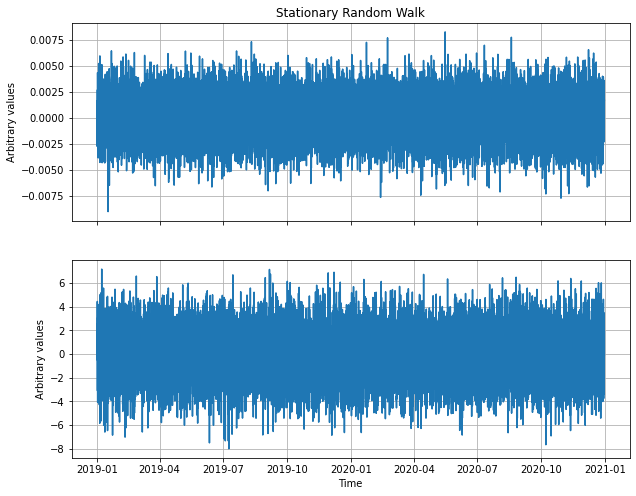

In [8]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create index
nhours = 365*2*24 # let's create 2 year's worth of hourly data
var = 0.002      # arbitrarily set a scale
dti = pd.date_range("2019-01-01",
                    periods=nhours,
                    freq="H") # we use date_range to create a time-series with dates/times that make physical sense 

# Generate normal distribution
random_walk0 = pd.DataFrame(index=dti,
                   data=np.random.normal(size=nhours) * var)  # using a normal random distribution, scaled using 'var' (arbitrarily)

# Plot it and see what we made
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10,8))
ax0.plot(random_walk0)
# annotate the figure
ax0.grid(True)
ax0.set_title('Stationary Random Walk')
ax0.set_ylabel('Arbitrary values')


## change the scale parameter (var), for illustration
# Create index
periods = 2000
var = 2
dti = pd.date_range("2019-01-01",
                    periods=nhours,
                    freq="H")

# Generate normal distribution
random_walk1 = pd.DataFrame(index=dti,
                   data=np.random.normal(size=nhours)  * var)

# Plot it
ax1.plot(random_walk1)
# annotate the figure
ax1.grid(True)

ax1.set_xlabel('Time')
ax1.set_ylabel('Arbitrary values')

plt.show()

# Note how the look/distribution of the data series in each case is the same, 
# except that the magnitude of the number and range of the data have changed. 

Text(0, 0.5, 'Periodic + random walk')

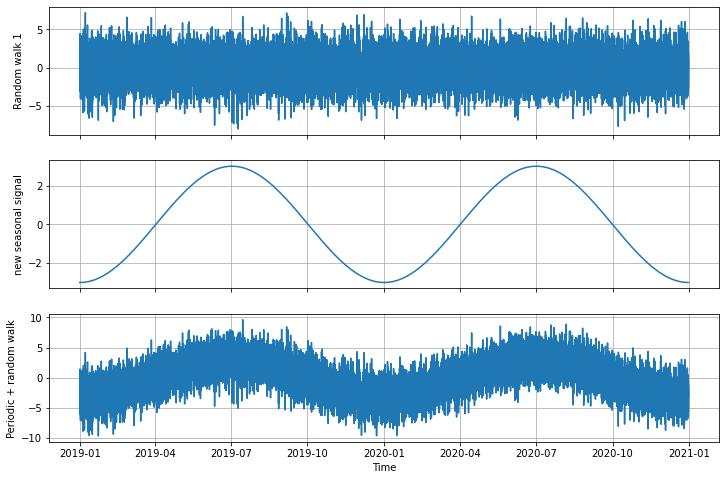

In [9]:
## Adding seasonality to random_walk1 and create periodic_walk1

# Add a new periodic element:
# Create some indices for a hypotetical time series (that will be our "time-axis")
# We need to create as many time-steps as in the random_walk time series
# random_walk1 was created to span 2 years, hourly,
# so let's create two sine waves that fit over that period. 

# create a time variable
t = np.linspace(0,365*2,num=nhours,endpoint=False,retstep=False)

# create a periodic sequence of value of correct length
period=365
Amplitude = 3 # that's just made up, so the periodic signal 'looks a bit bigger'
omega = 2*np.pi/period
phase_shift = 365/4 # we'll also add a phase shift so summers look high and winters look low
new_data = Amplitude*np.sin(omega*(t-phase_shift))
periodic_element = pd.DataFrame(index=dti,data=new_data)

# adding the periodic signal to the random walk 
periodic_walk1 = random_walk1 + periodic_element

# Plot it
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(12,8))
ax0.plot(random_walk1)
ax0.grid(True)
#ax0.set_xlabel('Time')
ax0.set_ylabel('Random walk 1')

ax1.plot(periodic_element)
ax1.grid(True)
#ax1.set_xlabel('Time')
ax1.set_ylabel('new seasonal signal')

ax2.plot(periodic_walk1)
ax2.grid(True)
ax2.set_xlabel('Time')
ax2.set_ylabel('Periodic + random walk')



### Checking for stationarity

There are various ways to [check for stationarity in python](https://analyzingalpha.com/check-time-series-stationarity-python). 

Visual inspection is the easiest method, but parametric tests also exist, such as the `Augmented Dicky-Fuller (ADF)` and the `Zivot-Andrews (ZA)` tests. 

The ADF test is the most commonly used, but the ZA test can be more robust, and actually recommanded if there are statistical breaks in the time series. These tests are also sometimes called **'unit root tests'**. Since these tests are based on different assumptions, [it is not uncommon that they lead to conflicting answers!](https://otexts.com/fpp2/stationarity.html) Ultimately, it is up to the analyst to convince him/herself that the results make sense. These tools are just there to help. 

Let's show how these tests could be applied here. They are available from the `statsmodel` library. You are refered to the documentation for details: [`adfuller`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html), [`zivot_andrews`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.zivot_andrews.html.).

As always with statistical tests, the challenge, beyond implementation, is to know how to interpretate the result. This can be quite difficult. In this case, the following [post on analyzingalpha.com](https://analyzingalpha.com/check-time-series-stationarity-python) provides a good discussion. 


In [30]:
# applying the augmented Dicky-Fuller algorithm to random_walk1 (no trend present):
from statsmodels.tsa.stattools import adfuller
t_stat, p_value, _, _, critical_values, _  = adfuller(random_walk1, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')     
print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

ADF Statistic: -132.13
Critial Values:
   1%, -3.43
Critial Values:
   5%, -2.86
Critial Values:
   10%, -2.57

p-value: 0.00
Stationary


In [31]:
# applying the augmented Dicky-Fuller algorithm to periodic_walk1 (periodic trend present):
from statsmodels.tsa.stattools import adfuller
t_stat, p_value, _, _, critical_values, _  = adfuller(periodic_walk1, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')     
print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

ADF Statistic: -2.73
Critial Values:
   1%, -3.43
Critial Values:
   5%, -2.86
Critial Values:
   10%, -2.57

p-value: 0.07
Non-Stationary


**Interpretation**: 
The ADF statistics (-130s) for the 'random_walk1' case is larger than the critical values (around -2.5, -3.5). Therefore, we can reject the null hypothesis, that the process is non-stationary, i.e. the random process is stationary (we created that way by design). When the p-value is greater than 5%, we accept the null hypothesis (or more accurately, we cannot reject with it with higher than 5% confidence). 

We see that the ADF statistic for the 'periodic_walk1' variable, which includes a periodic element, is much less. The p-value is just above 0.05, concluding correctly that the time series is non-stationary. We know this is correct (we added the seasonal signal!). This shows, though, that signal-to-noise is a critical consideration. Had we reduced the amplitude of the seasonal signal added from 3, to 2, the ADF test would have incorrectly concluded that the signal was stationary (go back in the code and try it).

The Zivot-Andrews test would be implemented (and interpreted) as follows:

In [32]:
# applying the augmented Zivot-Andrews algorithm to random_walk1 (no trend present):
from statsmodels.tsa.stattools import zivot_andrews
t_stat, p_value, critical_values, _, _ = zivot_andrews(random_walk1)
print(f'Zivot-Andrews Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

Zivot-Andrews Statistic: -132.20
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary


In [33]:
# applying the augmented Zivot-Andrews algorithm to periodic_walk1 (periodic trend present):
from statsmodels.tsa.stattools import zivot_andrews
t_stat, p_value, critical_values, _, _ = zivot_andrews(periodic_walk1)
print(f'Zivot-Andrews Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

Zivot-Andrews Statistic: -3.48
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.69
Non-Stationary


We see how the Zivot_Andrews results are much clearer in this case, with a p-values for the periodic case that is undeniably larger than 5% (we would make a big mistake by rejecting the null-hypothesis of non-stationarity!). This example shows how one needs to understand how parameteric tests behave and probably shouldn't 'just believe' them blindly. In this example, the critical aspect is of course the signal-to-noise in 'periodic_walk1'. The amplitude of the periodic signal is weak compared to the magnitude of the random noise, and this can make it harder for the tests to detect the non-stationarity. This shows also that there is not aways a clear line between weak-stationarity and non-stationarity. 

### Example of detrending 

The [`statsmodels`](https://www.statsmodels.org/stable/index.html) library is a python module that provides tools to estimate many different statistical models, run statistical tests and do statistical data exploration. 'statsmodels' used to be part of scikit-learn, but it is now a stand-alone project. 

We could use tools from the `statmodels` python module, such as [`seasonal_decompose`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html), to test for, and remove seasonality. `seasonal_decompose` relies on a moving average. To see all of `statsmodels` tools for time series, go [here](https://www.statsmodels.org/dev/user-guide.html#time-series-analysis). 

Note that `seasonal_decompose` is a rather naive decomposition and we will see below that the results are not completely clear. More sophisticated methods would be preferred. The `model` option of seasonal_decomopose can be either additive or multiplicative. This refers to:

Additive model: Y[t] = T[t] + S[t] + e[t]

Multiplicative model: Y[t] = T[t] * S[t] * e[t]

The results are obtained by first estimating the trend (T[t]) by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

Let's apply this to the random walk, the random walk data with added periodicity just created above and also to a new case, with a long-term trend added.    

You are encourage to explore the tools offered by 'statsmodels' on your own. 

Text(0, 0.5, 'Trend + Periodic + random walk')

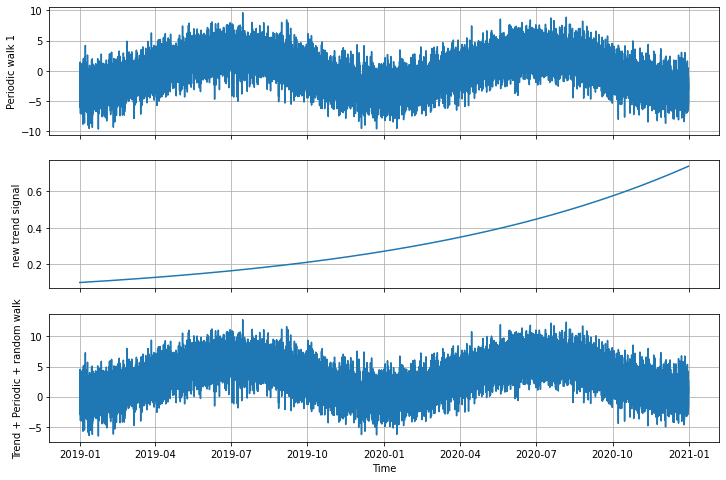

In [14]:
## Adding a trend to periodic_walk1: trendy_walk1

# Add a new trend element
# Create some indices for a hypotetical time series (that will be our "time-axis")
# We need to create as many time-steps as in the random_walk time series
# random_walk1 was created to span 2 years, hourly
# so let's create two sine waves over that time frame. 

# we don't need to recreate 't', we'll reuse it from above. 
#t = np.linspace(0,365*2,num=nhours,endpoint=False,retstep=False)

# add an exponential, but weakly increasing trend
t_half = 365*1
modulation = 0.01
new_trend0 = modulation*np.exp(np.divide(t,t_half))

trendy_element = pd.DataFrame(index=dti,data=new_trend0)

# adding the periodic signal to the random walk and an offset too
offset = 3

trendy_walk1 = periodic_walk1 + trendy_element + offset

# Plot it
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(12,8))
ax0.plot(periodic_walk1)
ax0.grid(True)
#ax0.set_xlabel('Time')
ax0.set_ylabel('Periodic walk 1')

ax1.plot(trendy_element)
ax1.grid(True)
#ax1.set_xlabel('Time')
ax1.set_ylabel('new trend signal')

ax2.plot(trendy_walk1)
ax2.grid(True)
ax2.set_xlabel('Time')
ax2.set_ylabel('Trend + Periodic + random walk')



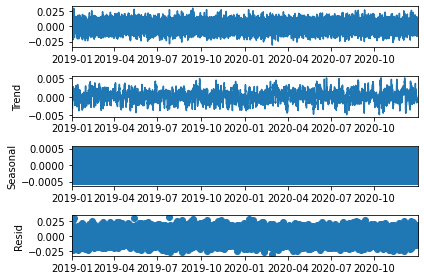

In [35]:
# Applying seasonal_decompose to random_walk1: 
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(random_walk1)
sd.plot()
plt.show()

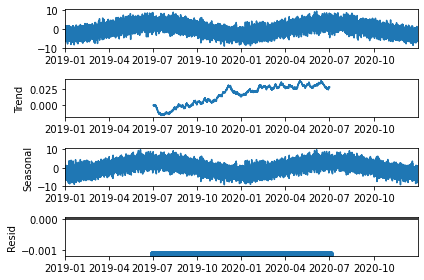

In [5]:
# Applying seasonal_decompose to periodic_walk1(with periodic signal), prescribing the period of the periodic signal
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(periodic_walk1,model='additive',period=365*24)
sd.plot()
plt.show()

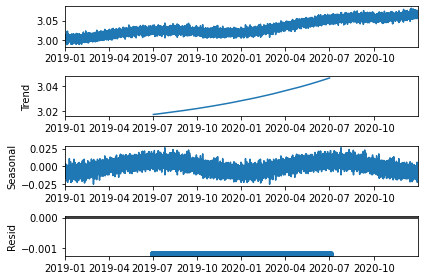

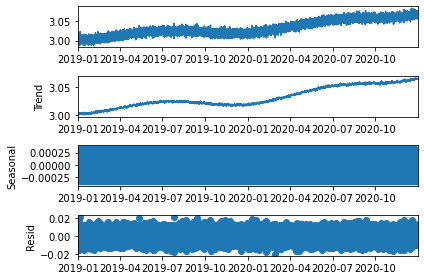

In [69]:
# Applying seasonal_decompose to trendy_walk1(with trend and periodic signal)
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(trendy_walk1,period=365*24)
sd.plot()
plt.show()

# by removing the periodic signal, the trend is revealed, but most of the noise is now included
# in the seasonal signal.


# Applying seasonal_decompose to trendy_walk1(with trend and periodic signal) but without specifying the period
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(trendy_walk1)
sd.plot()
plt.show()

# we see here too that the weak signal-to-noise of the periodic signal is a problem. 
# seasonal_decompose is not able to separate the periodic trend from the seasonal signal. 
# it is overfitting the data, in that it is not separating trend from seasonal signal.  

# although the seasonal_decompose function could be useful, these tests show that care
# must be given so as to be misled in our interpretations. 

## Autocorrelation
A non-stationary time series data will show significant correlation between itself and a lagged version of itself, with a correlation coefficient and significance that will decay to zero. This is because non-stationary series have temporal patterns so the value of the next observations is related to the value next to it. [Autocorrelation](https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html), or corelation with lagged versions of self, can be used to show correlation time-scales in time series. 

Autocorelation plots can be read to see if there are periodic patterns, or any memory in the data. 

Pandas provides a built-in function to plot the autocorrelation function: [`pandas.plotting.autocorrelation_plot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html). 


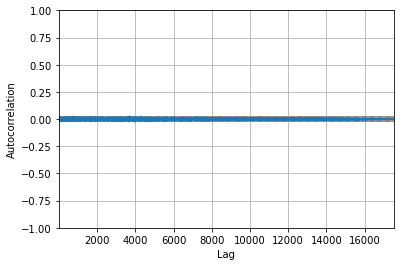

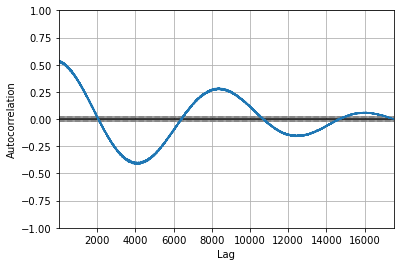

In [15]:
import pandas as pd
# Plot the autocorrelation function with pandas

# for random_walk1: each sample is independent, no correlations
pd.plotting.autocorrelation_plot(random_walk1)
plt.show()

# for periodic_walk1: there is a seasonal signal, although hour to hour samples vary (with independent noise)
# there is a seasonal long term memory trend
pd.plotting.autocorrelation_plot(periodic_walk1)
plt.show()



Looking at the result, we see a cross-over to zero correlation given a lag of 2000 hours, or shifting the data by about 3 months (2000/24/30=2.8). Anti-correlation (i.e. antiphase) is reached given a lag of 4000 hours, or 6 months. Given the shape of the autocorrelation function, we see good correlation again with a lag of ~8000+ hours (12 months),  indicative of the annual signal in the data. Autocorrelation function can be interpreted to show 'memory' in the data. 

The grey lines (barely visible here) show the 95% and 99% confidence intervals for the correlation. We could make this 'worst' by changing the signal-to-noise.  

---

# Modeling time series data

One of the tenet of time series analyis, or statistical forecasting of time series, is that: 

$
Data = Signal + Noise
$

Many approaches to time series analysis therefore try to decompose the data into an interpretable, signal, part and into uninterpretable residuals, which ideally are white noise. The signal can be additive, with trends, periods, and errors, e.g. $X_t=T_t+S_t+E_t$, or multiplicative, e.g. $X_t=T_t \cdot S_t \cdot E_t$, where the amplitude of variations of the data could be changing through time. 

There are many types of models for time series data, each of which can take various forms and represent different stochastic processes. However, three broad classes are very common and of practical importance: 
1.  the autoregressive (AR) models, 
2.  the integrated (I) models, and 
3.  the moving average (MA) models. 
   
These three types of models all depend linearly on previous data points (other classes of models exist), and use that information to make a forecast into the future. One is generally interested in [developing these models to forecast](https://medium.com/wegaw/time-series-forecasting-in-python-from-zero-to-neural-networks-in-only-a-month-8e12d6a6e2f4), statistically, the (possibly future) behaviour of the data. 

Combinations of ideas underlying the AR and MA models produce  **autoregressive moving average ([ARMA](https://en.wikipedia.org/wiki/Autoregressive–moving-average_model)) models**, while combination of all three types yields the **autoregressive integrated moving average ([ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)) models** . The **autoregressive fractionally integrated moving average model ([ARFIMA](https://en.wikipedia.org/wiki/Autoregressive_fractionally_integrated_moving_average))**  generalizes all of this by allowing non-integer values of the 'differencing parameter'.



### AR(p) (Auto Regressive Models)
[Autoregressive (AR(p)) models](https://otexts.com/fpp2/AR.html) are models which use previous values to predict the current value (or guess the next one) of the same variable. They are like regression models, but instead of using lagged values of the variable itself as a predictor. The number of previous values used is called the **`order`** of the AR model. 

AR(p) models have the following form: 

$
X_t=c+\sum_{i=1}^{p} \phi_i X_{t-i}+\epsilon_t
$

where $\phi_i$ are parameters that depend on the order of the AR model, $c$ is a constant and $\epsilon_t$ is random, white noise, error. Error terms $\varepsilon_t$ are generally assumed to be independent identically distributed random variables (i.i.d.) sampled from a normal distribution with zero mean: $\varepsilon _{t} ~ N(0,\sigma^2)$ where $\sigma^2$ is the variance. 

Given that definition, the expanded form of AR(1) would be for $X_t$:

$
X_t = c + (\phi_1)X_{t-1} + \epsilon_t
$

and AR(2) would be

$
X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2}  + \epsilon_t
$

etc. 

The expanded forms show clearly how the current value $X_t$ is obtained from the lagged values $X_{t-i}$.

Now let's also expand the form of $X_{t-1}$. AR(1) for $X_{t-1}$ would be

$
X_{t-1} = c + \phi_1 X_{t-2}  + \epsilon_{t-1}
$

So we can say that 

$
X_t = c + (\phi_1) \left(c + \phi_1 X_{t-2}  + \epsilon_{t-1} \right) + \epsilon_t
$

which we could rewrite as

$
X_t = c^* + (\phi_1)^2 X_{t-2}  + \phi_1 \epsilon_{t-1} + \epsilon_t
$

and we see that $X_t$ is not only dependent on $X_{t-1}$, but also on $X_{t-2}$ since $X_{t-1}$ did depend on it. In fact, we can show that 

$
X_t = \frac{c}{1-\phi} + (\phi_1)^t X_{1}  + \phi_1^{t-1} \epsilon_{2} + \phi_1^{t-2} \epsilon_{3}+ ... + \epsilon_t
$

and we see that the current value of $X_t$, to a very small degree (i.e. through $\phi^t$, does actually depend, in a small way, even on the very first value of the data series, $X_1$). For this reason, we say that AR models are [`long memory models`](https://www.youtube.com/watch?v=Mc6sBAUdDP4&t=3s). 

AR models can be restricted to stationary data if the parameters $\phi$ [obey certain rules](https://otexts.com/fpp2/AR.html):
- For AR(1): $-1 < \phi < 1$
- For AR(2): $-1 < \phi_2 < 1, \phi_1 + \phi_2 <1, \phi_2 - \phi_1 <1$

for p>2, restrictions are more complicated. Algorithms typically take care of these rules automatically when estimating AR models (i.g. fitting $\phi$ values). 

To illustrate AR models, let's try to code a dummy one here: 

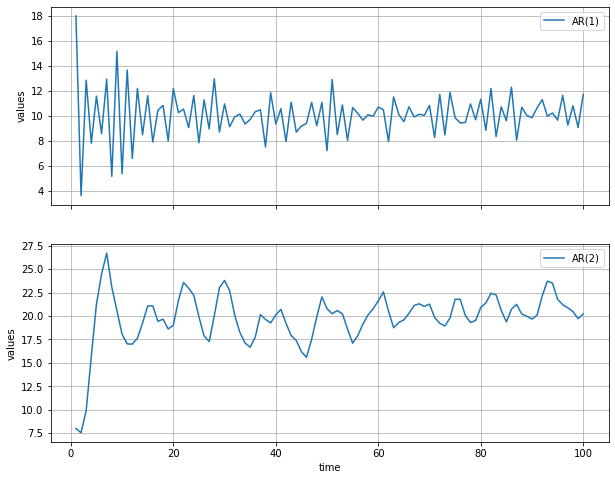

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# create some indices for a hypotetical time series (that will be our "time-axis")
L=100 # set the number of time steps
t = [i for i in range(1,L+1)]

# Create normally distributed random number, with mean=0, and variance 1, or 0.8
mu, sigma0, sigma1 = 0, 2, 1
AR1_0 = np.random.normal(mu,sigma0,1)
epsilon = np.random.normal(mu,sigma1,L)

# initialize some arrays to collect the results
AR1 = np.zeros((L,1))
AR2 = np.zeros((L,1))

# initialize AR1_t-1 with any number to start the iteration
AR1[0]=18 

# initialize AR2_t-1 and AR2_t-2 with any numbers to start the iteration
AR2[0]=8
AR2[1]=AR2[0]+AR1_0


# time step a made up AR(1) model, starting from index 1 (t), not 0 (0 is t-1)
for i in range(1,L):
    AR1[i] = 18 - 0.8*AR1[i-1] + epsilon[i]

# time step a made up AR(2) model, starting from index 2 (t), not 1, 0 (1 is t-1; 0 is t-2)
for i in range(2,L):
    AR2[i] = 8 + 1.3*AR2[i-1] - 0.7*AR2[i-2] + epsilon[i]
    
# Plot it using a custom function
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10,8))

ax0.plot(t[0:100],AR1[0:100], label="AR(1)") 
ax0.legend()
ax0.grid()
ax0.set_ylabel('values')
  
ax1.plot(t[0:100],AR2[0:100], label="AR(2)") 
ax1.legend()
ax1.grid()
ax1.set_ylabel('values')
ax1.set_xlabel('time')

plt.show()    

### MA(q) (Moving Average Models)

[Moving average (MA(q)) model](https://otexts.com/fpp2/MA.html) use past errors in the model to predict future values. The “order” of an MA model refers to how many steps are taken back in time to predict the next value.

$
X_t=\mu + \epsilon_t + \sum_{i=1}^{q} \theta_i \epsilon_{t-i}
$

where the $\theta_i$ are parameters, $\mu$ is the expectation of $X_t$ (i.e. the average, which ideally should be 0 for detrended time series), and $\epsilon_t$ and $\epsilon_{t-i}$ are also white noice random errors. 

Given that definition, the expanded form of MA(1) would be: 

$
X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1}
$


We can also expand for $X_{t-1}$: 

$
X_{t-1} = \mu + \epsilon_{t-1} + \theta_1 \epsilon_{t-2}
$

and we see that the value of X at time $t-1$ depended on the error of the previous time step, but when comparing the results for $X_t$ and $X_{t-1}$, we see that the error from two time steps ago is not longer affecting the prediction of the current value of $X_t$. That error, from q+1 steps away in the past, does not affect the predictions of $X_t$. For this reason, MA models are called [`short memory models`](https://www.youtube.com/watch?v=zNLG8tsA_Go).


Looking back that AR(1) example above, expanded to show the influence of the first observation ($X_1$): 

$
X_t = \frac{c}{1-\phi} + (\phi_1)^t X_{1}  + \left[ \phi_1^{t-1} \epsilon_{2} + \phi_1^{t-2} \epsilon_{3}+ ... + \epsilon_t \right]
$

we see that the term in square bracket is actually nothing else but a large moving average term, essentially collecting all the short memory errors. This suggests that [AR and MA models can be linked](https://otexts.com/fpp2/MA.html), leading to the next level of complexity, i.e. ARMA, ARIMA, etc. models. 

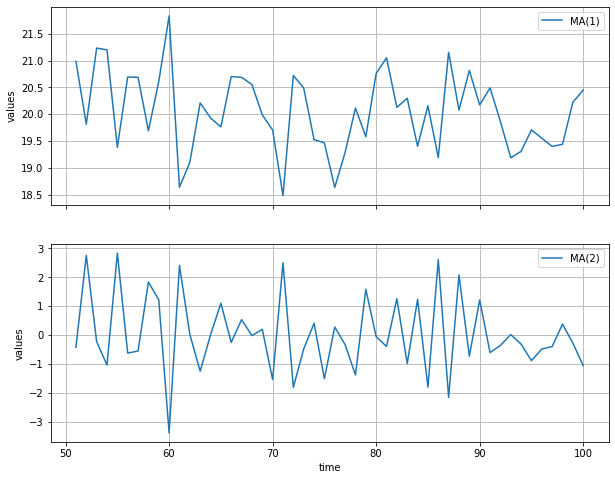

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# create some indices for a hypotetical time series (that will be our "time-axis")
L=100 # set the number of time steps
t = [i for i in range(1,L+1)]

# Create normally distributed random number, with mean=0, and variance 1, or 0.8
mu, sigma1 = 0, 1
epsilon = np.random.normal(mu,sigma1,L)

# initialize some arrays to collect the results
MA1 = np.zeros((L,1))
MA2 = np.zeros((L,1))

# initialize AR1_t-1 with a random seed
MA1[0]=20 #AR1_0

MA2[0]=0
MA2[1]=AR1_0


# time step a made up AR(1) model, starting from index 1 (t), not 0 (0 is t-1)
for i in range(1,L):
    MA1[i] = 20 + 0.8*epsilon[i-1]

# time step a made up AR(2) model, starting from index 2 (t), not 1, 0 (1 is t-1; 0 is t-2)
for i in range(2,L):
    MA2[i] = epsilon[i]-epsilon[i-1]+0.8*epsilon[i-2]
    
# Plot it using a custom function
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10,8))
# plot the last half (the first half is mostly just busy converging to a stationary state)
ax0.plot(t[50:100],MA1[50:100], label="MA(1)") 
ax0.legend()
ax0.grid()
ax0.set_ylabel('values')
  
ax1.plot(t[50:100],MA2[50:100], label="MA(2)") 
ax1.legend()
ax1.grid()
ax1.set_ylabel('values')
ax1.set_xlabel('time')

plt.show()    

### The Lag Operator 'L'

Another common notation in time-series analysis makes use of the so-called [`lag operator`](https://en.wikipedia.org/wiki/Lag_operator). Given a time series $X={X_1, X_2,...}$, then the 'lag operator' **`L`** is defined such that 

$
LX_t=X_{t-1}
$

This can be generalized by raising the lag operator to an arbitrary interger power, such that: 

$
L^{k}X_t = X_{t-k}
$

(Noting that if $k < 0$, then $L^{-k} X_t = X_{t+k}). 

[With this notation](https://en.wikipedia.org/wiki/Autoregressive–moving-average_model), the AR(p) model could be written: 

$
\epsilon_t = \left(1 - \sum_{i=1}^{p} \phi_i L^i \right) X_t = \phi(L)X_t
$

where $\phi(L)$ now represents a polynomial:

$
\phi(L) = 1 - \sum_{i=1}^{p} L^i
$

and the MA(q) model becomes 

$
X_t = \left(1 + \sum_{i=1}^{q} \theta_i L^i \right) \epsilon_t = \theta(L)\epsilon_t
$

where $\theta(L)$ represent the polynomial

$
\theta(L) = 1 + \sum_{i=1}^q \theta_i L^i
$



### ARMA(p,q) (Auto Regressive Moving Average Models)

[ARMA models are a combination of AR and MA models](https://en.wikipedia.org/wiki/Autoregressive–moving-average_model). The AR part involves regressing the variable on its own lagged (i.e., past) values. The MA part involves modeling the error term as a linear combination of error terms occurring contemporaneously and at various times in the past. ARMA requires two hyperparameters, ARMA(p, q), with (p) the orders of the AR model and (q) the order of the MA model. ARMA is applicable to stationary time series.

The ARMA model is then the combination of AR(p) and MA(q):

$
X_t = c + \epsilon_t + \sum_{i=1}^{p} \phi_i X_{t-i} +\sum_{i=1}^{q} \theta_i \epsilon_{t-i}
$

Given this definition, ARMA(1,1) would expand into: 

$
X_t = c + \epsilon_t + \phi_1 X_{t-1} + \theta_1 \epsilon_{t-1}.
$

One can also write the ARMA model using the lag operator (this is often the case in the literature). Assuming c=0, we can rearrange ARMA as:

$
X_t - \sum_{i=1}^{p} \phi_i X_{t-i} = \epsilon_t  + \sum_{i=1}^{q} \theta_i \epsilon_{t-i}
$

or 

$
\left( 1 - \sum_{i=1}^{p} \phi_i \right) X_t = \left( 1 + \sum_{i=1}^{q} \theta_i \right) \epsilon_t
$

which becomes simply: 

$
\phi(L)X_t = \theta(L)\epsilon_t
$

or also 

$
\frac{\phi(L)}{\theta(L)}X_t=\epsilon_t
$


**Choosing values for p and q**: The crux is to choose the orders p and q. In the parlance of machine learning, p and q could be considered `hyperparameters`. By fixing values of p and q, the parameters $\phi_i$ and $\theta_i$ can be fitted by least-square regression to minimize the norm of the error term. In general, one seeks the smallest values of p and q that provide 'acceptable fit' to the data. Increasing p and q will yield increasingly better fits, but this is because the model includes more and more of the data and there are memory and computational costs to pay for having to know more things in a calculation. 

Recall that increasing values of p or q implies an increasing number of unknown $\phi$ and $\theta$ fitting parameters too. Pushing this to the extreme, one could have almost as many tuning parameters $\phi$ and $\theta$ as there are number of points to fit ... that would clearly be a case of overfitting! Because of this, the values to choose for p and q are also releated to the bias-variance tradeoff problem, so diagnostic tools for model selection, such as the [`Akaike Informration Criterion (AIC)`](https://en.wikipedia.org/wiki/Akaike_information_criterion), can also be used to select p and q (Note, a new [Bridge Criterion](https://ieeexplore.ieee.org/document/7953690) is now also available, that bridges uses of AIC with the Bayesian Information Criterion, BIC).    


**Evolutions of ARMA**: Evolutions of AR model are Vector Autoregressive Models (VAR). VARS are similar to autoregressive models but using several time series to predict each other. An example of VAR would be if we had, let's say, 4 variables, 'a', 'b', 'c' and 'd', and we'd use previous times steps of all 4 to predict the evolution of one of them, e.g. 'a_next'=f([a,b,c,d],p), with (p) being again the order.
>(NB: Often, when the word 'vector' is used in statistics, what is meant is 'matrices', i.e with each data series constituting a row or column of data. Use of linear alegra is then able to generalize solutions.). 

Non-linear AR (NAR) and MA (NMA) models also exist. The 'non-linearity' refers to how past observations $X_t$ are related to $X_t$. In AR and MA, as shown above, the relationship is linear (i.e. just related by parameters $\phi_i$ and $\theta_i$). 


### ARIMA(p,d,q) (Autoregressive integrated moving average)

[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) is the next step up from ARMA. The 'I' (which stands for 'integrated') in ARIMA refers to a differencing step used to eliminate non-stationarity in the original time-series, i.e. to detrend the data. The 'I' therefore indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). 

ARIMA models can be used for non-stationary models, but only if the non-stationarity is due to a trend (including periodicity, seasonality), not if the non-stationarity affects other, higher, moments (e.g. variance, etc.). 

The parameters p, d, q needed in ARIMA(p,d,q) are non-negative integers. p and q are the orders of the AR and MA sub-models. The new parameter 'd' is the 'degree of differencing', which is the number of times the data have had past values subtracted. Therefore, ARIMA(1,0,0)=AR(1), ARIMA(0,0,1)=MA(1), ARIMA(1,0,1)=ARMA(1,1). 


Evolutions of ARIMA models are `seasonal ARIMA` models. These are typically written as: ARIMA(p,d,q)(P,D,Q)$_S$. 
The notation (P,D,Q)$_S$ refers to: 
- P: number of seasonal AR terms
- D: number of seasonal differences
- Q: number of seasonal MA terms
- S: length of the season (how many data points constitute a 'season', or a period)

For example, ARIMA(1,0,1)(2,1,0)$_{12}$ would imply the following: 
1. We see that D=1, so we need to first differnce our data. Since S=12, the season is 12 points long. We are probably dealing with monthly averaged data. So our first action will be do difference the data with another data point, 12 time steps before, to create a new 'stationary' data series that we are going to call $W_t$: 

$
X_t - X_{t-12} = W_t
$

2. Looking at the AR pieces now, p=1 and P=2. The p=1 term means that this is an AR(1) model so there will be $W_{t-1}$ term, with its associated $\phi_{1}$ parameter. The P=2 term, implies another two seasonally-shifted terms, by 1 x the season length, and 2 x the season length, or $W_{t-12}$ and $W_{t-(2\cdot 12=24)}$, and each will of course also get a new $\phi$ parameter. 
3. The MA part of the model only involves one error term, so just the $\theta_1 \epsilon_{t-1}$ term. 
   
ARIMA(1,0,1)(2,1,0)$_{12}$ therefore has the form:

$
X_t - X_{t-12} = W_t \\
W_t = c + \phi_1 W_{t-1} + \phi_2 W{t-12} + \phi_3 W_{t-(24)} + \theta_1 \epsilon_{t-1} + \epsilon_t
$


## Markov Chains

Another way to model time series are Markov Chains. These are particularly useful when a process can take on a finite number of states, with varying probabilities. 

A system consisting of mutually exclusive states and probabilistic transitions between them is called a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) (after the Russian mathematician Andrey Markov).

They are often linked to a technique called [`Markov Chain Monte Carlo`](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), which are a class of algorithms for sampling from a probability distribution. This is very useful for numerical error propagation. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The [`Metropolis-Hastings algorightm`](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm) is also key to certain non-linear global optimization algorithms, such as [`simulated annealing`](https://en.wikipedia.org/wiki/Simulated_annealing). 

One widely used analogy to explain Markov Chains is the 'drunken sailor' moving between his ship to the local pub (...the sailor being so drunk that he can move forwards, backwards, or not move at all):

> [A drunken sailor moves from a tavern to his ship. The distance between the tavern and the ship is N steps. With each intermediate step, the sailor has chance **f** of stepping forward, chance **b** of stepping backward, and chance of **1-f-b** of standing still. Where does the sailor end up at the end of the day?](https://medium.com/pragmatic-programmers/what-shall-we-do-with-a-drunken-sailor-c57d9b61339d)


To illustrate, assume there are 4 steps (N=4) between the ship and the tavern.

![drunkensailor](../../img/drunkensailor.png)

In this case, the system comprising the sailor, the tavern, and the path with steps between the two can be in one of the N+1=5 **states** S[i]: 
1. the sailor is in the tavern; 
2. the sailor is 1 step away from the tavern; 
3. the sailor is halfway from the tavern (i.e. 2 steps from anything); 
4. the sailor is 1 step away from the ship;  
5. the sailor is on the ship. 
   
The probability of being in each state is **p[i]**, and the sum of all probabilities is 1 (the sailor must be at least somewhere).

There are also the probabilities **q[i,j]** of **moving** from the state S[i] to the state S[j]. For instance, if we were to set q[0,0], this could mean that the sailor **is** (S[i]) in the tavern, and **going** to the tavern (S[j]), so he has not actually gone anywhere in this case, but the quantity q[i,j] let's us represent the probability of each move happeneing. In this case, from the tavern, the sailor cannot go backwards, only forwrads towards the ship, so q[0,0]=1-f (i.e. the probability of staying in the taver is equal to the probability of *not* moving forward).

Imagine, we start with the state that the sailor **is** in the tavern, so we can say p[0]=1, and set all other p[i]=0. 

From that starting point, we can now imagine what happens during the next step, i.e. the sailor can either move one step forward (i.e. out of the tavern, i.e. p[0] would decrease and p[1] would increase), or stay in the tavern. Whatever happens, though, the drunken sailor has **no memory** of what he did last time...as he is drunk, so each new move is independent of the last move, in a memoryless fashion. 

The fact that moves are memoryless does not mean that probabilities of being a state cannot be calculated between steps though. During the second step, the probability of being in step 2, p[2] will depend on wether the sailor was in p[1] or p[0] after step 1, and this depends on the probabilities of moving (q[i,j], which ultimately depends on probabilities **f** and **b** or moving forward and backwards, and on the probabilities of being somewhere (p[i]). 

To calculate the probabilities of the sailor being in any given state at a given time step, we simply need to keep track of all probabilities or getting there (q) from each current state (p), and sum them. 

$
p’[i] = sum(p[j] · q[j,i])
$

For example, for the mid-way state, N=2, equidistant between the ship and the tavern, the probability of being there, i.e. in the new state p'[2] from any previous state 'p', can be represented by:

$
p'[2] = q[0,2] · p[0] + q[1,2]· p[1] + q[2,2]· p[2] + q[3,2]· p[3] + q[4,2]· p[4]
$

and given our knowledge of the probabilities, we can simplify this as: 

$
p’[2] = 0 · p[0] + f · p[1] + (1-f-b) · p[2] + b · p[3] + 0 · p[4]
$

We get get to N=2 by moving from step 1 forward, moving from step 3 backwards, or not moving from step 2. We cannot get to step 2 directly from step 0 or 4 (the tavern or the ship) as this would requires two steps (the sailor can only make one step at a time). 

We can apply the same logic and calculate the probablilites of being anywhere. For example, the probability of being in step 1, p'[1] would be: 

$
p'[1]=q[0,1] · p[0] + q[1,1]· p[1] + q[2,1]· p[2] + q[3,1]· p[3] + q[4,1]· p[4] \\
p’[1] = f · p[0] + (1-f-b) · p[1] + b · p[2] + 0 · p[3] + 0 · p[4]  
$

The 'ps' and the 'qs' for all cases can be quantified and arranged into matrices **'P'** and **'Q'**, such that $P' = P · Q$. **P** is the state matrix, while **Q** is called the **transition** matrix. In the case of N=4, we see that the matrices P and Q are 5x5, or N+1 x N+1. A Markovian system is one where all we know is the current state and transition probabilities, but we don't know (or keep track) of what the previous states were (they don't affect the transition probabilities).


Markovian systems ultimately become stationary in the sense that the distribution of the probabilities of being in each state converge towards stable distributions. When that happens,  $P = P’ = P’’ = P’’’ = ... = π$, that is the probability matrix that sets the probability of being in each state no longer evolves with each new iteration (i.e. the distribution of the probabilities describing the likelihood of being in each state p[i] doesn't change anymore with more iterations). When that happens, since p'[i]=p, we can write $\pi=P=P'$ and so

$
\pi = \pi \cdot Q
$

Since this represents a linear system, one could solve it for $\pi$ and we see that $\pi=eig(Q)$, so the probabilities of being in each state, given many steps through the random walk of the drunk sailor, are given by the eigenvalues of the transition matrix. Deriving this is beyond the scope of this introduction, but explanations can be found [here](https://en.wikipedia.org/wiki/Markov_chain). 

Here is a python example, assuming the drunken sailor is slightly more likely to go forward (f=0.7) than backward (b=0.2)...so maybe the sailor is not completely drunk yet. 

In [44]:
import numpy as np
# Initialize the constants
N, f, b = 4, 0.7, 0.2
# Initialize the transition matrix
Q = np.zeros((N + 1, N + 1))    # create a matrix of zeros, of size N+1 x N+1
Q[0,1] = f
Q[0,0] = 1 - f
Q[-1,-1] = 1 - b
Q[-1,-2] = b
for i in range(1,N):
    Q[i,i-1] = b
    Q[i,i] = 1 - b - f
    Q[i,i+1] = f

## check the size and make up of the Q matrix    
print(Q.shape)
print(Q)


# Find the eigenvalues and eigenvectors using Numpy's linear algebra solvers
evals, evecs = np.linalg.eig(Q.T)
pi = evecs[:, np.isclose(evals, 1)] 
print("the probabilities that the drunken sailor is in any state are:")
print(pi.T / pi.T.sum())


(5, 5)
[[0.3 0.7 0.  0.  0. ]
 [0.2 0.1 0.7 0.  0. ]
 [0.  0.2 0.1 0.7 0. ]
 [0.  0.  0.2 0.1 0.7]
 [0.  0.  0.  0.2 0.8]]
the probabilities that the drunken sailor is in any state are:
[[0.004769   0.01669151 0.05842027 0.20447094 0.71564829]]


# Spectral analysis and frequency domain analysis

So far, all the methods discussed applied to the so-called 'time domain'. 

It is possible, and often desireable, to transform the original detrended data (but still containing periodic signals) into the [`frequency domain`](https://en.wikipedia.org/wiki/Frequency_domain). 

Typical techniques for frequency domain analysis are the `Fourier transform` and `wavelet analysis`. There are various python implementations of these techniques. Note that applying these typically requires regularly spaced data. 

This [site](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.01-The-Basics-of-waves.html) provides an excellent resource to learn more about numerical implementations of Fourier transforms and inverse Fourier transforms in python.

The main thing to remember, from a practical perspective, is to use the **Fourier transform to go from the time to the frequency domain**, and the **inverse Fourier Transform to go from frequency domain back to the time domain**. 

By transforming a signal in the time domain into the frequency domain, we aim to decompose the signal into its dominant fequencies. We can then measure the magnitude of these fequencies, i.e. how important they are, that is how much they contribute to the overall signal. Frequencies can often be interpreted into specific processes (i.e. daily cycle, seasonality, interannual climate patterns, etc.). 

![timefreq](img/time_frequency.png)


Any signal in the time domain can be thought of as a superposition of sines and cosines, with given periods and amplitudes, to give a signal representation as a **frequency spectrum**. 

Mathematically, we know we can calculate the contribution of a basis vector to any vector by projecting the vector onto its basis. This is the 'dot' product of vectors. The same can be one with functions, by taking the 'inner product':

$
<f,g>=\int f(x) \cdot g(x)dx
$

If the inner product is 0, then the function g(x) does not contribute to f(x) in any ways. If it is non 0, then that is how much g(x) is in f(x). 

By 'projecting' any signal onto a series of orthogonal functions, such as sines and cosines of set frequencies, we can measure how important each of these basis function is to the signal, and therefore know which frequencies contribute to the signal. 

We note that in time, we talk about a period, but in space, we talk about a wavelength. Both are the same thing, they describe how long one wave is. 


### A quick [review of waves](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.01-The-Basics-of-waves.html)
We also recall that period (P) and frequency (f) are related as: 

$ 
P = 1/f
$

We also remember that sine waves can be represented as: 

$
y(t) = A sin(\omega t + \phi)
$

where $A$ is the amplitude of the wave, $\omega$ is the angular frequency, which specifies how many cycles occur in a second, in radians per second, and $\phi$ is the phase of the signal. 

If $T$ is the period and $f$ is the frequency of the wave, then $\omega$ has the following relationship to them:

$
\omega = \frac{2\pi}{T}=2 \pi f
$

The following code example generate two sine waves with time between 0 and 1 seconds and frequencies of 5 Hz and 10 Hz, all sampled at 100 Hz.


In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline

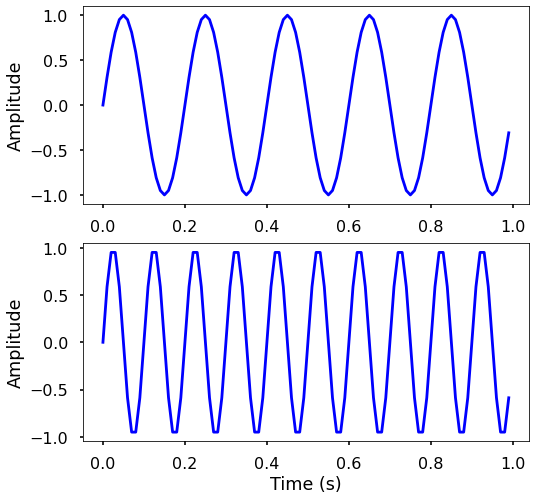

In [23]:
# sampling rate
sr = 100.0
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

# frequency of the signal
freq = 5   
y = np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 8))
plt.subplot(211)
plt.plot(t, y, 'b')
plt.ylabel('Amplitude')

freq = 10   
y = np.sin(2*np.pi*freq*t)

plt.subplot(212)
plt.plot(t, y, 'b')
plt.ylabel('Amplitude')

plt.xlabel('Time (s)')
plt.show()

Since we can add waves to one another to create any signal, one ought to also be able to ask how much do each cosine and sine wave contribute to the overall signal. Figuring this out is what the Discrete Fourier Transform does. The Fourier Transform decompose any signal into a sum of orthogonal sine and cosine waves of known periods (or frequencies).  

Let's create a 'fake' signal here, with known frequencies, for illustration.

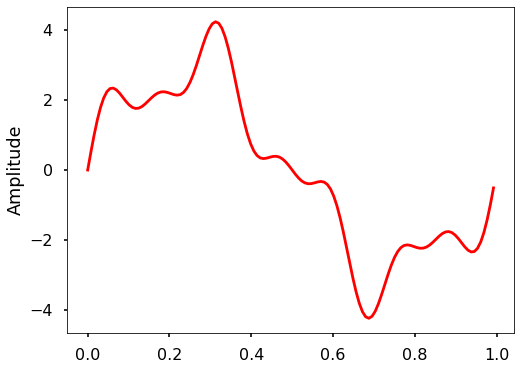

In [20]:
# sampling rate
sr = 128
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')

plt.show()

We will just here [look at a version of the Discrete Fourier Transform, which was coded 'by hand'](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html) for illustration, but this should not be used in practice! The Fast Fourier Transform (FFT) is an efficient algorithm to calculate the Fourier Transforms of a sequence. 

`fft` algorithms are so common and useful, there is a lot of incentive to develop increasingly more efficient and faster implementations. By all means, use pre-programmed versions of these, don't code your own (yours will be slow and memory inefficient!). We are here showing a simple version, simply to show how it works in principle. 

Here is a [simple implementation](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html) of the Discrete Fourier Transform.

In [26]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

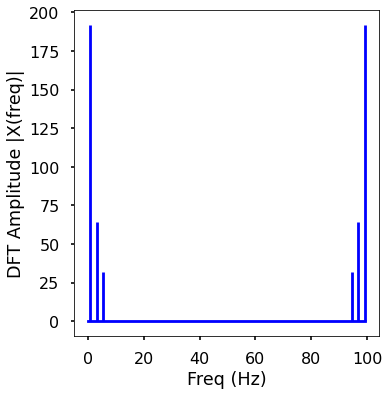

In [33]:
X = DFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12,6))
plt.subplot(121)
plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.show()



We can see that the output of the DFT is symmetric at half of the sampling rate (which was set at 100 in this dummy test). Half of the sampling rate is called the **Nyquist frequency**. This is the highest frequency we can isolate from a disctete signal because to fit a sine/cosine wave, we need at least 2 observations.

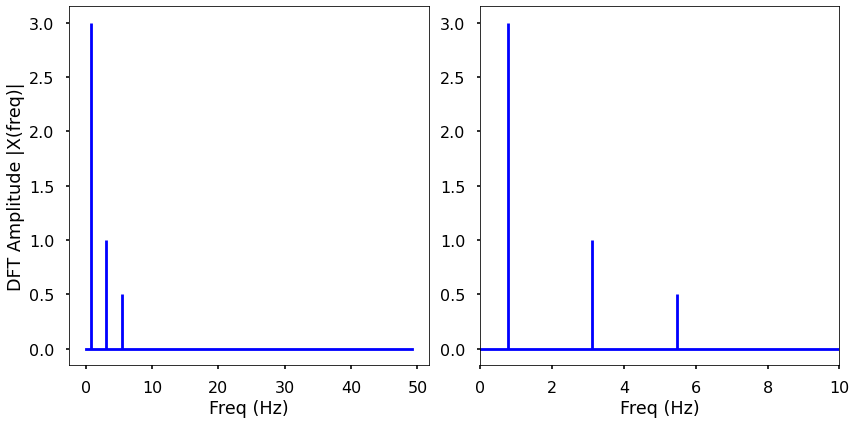

In [34]:
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 10)
plt.tight_layout()
plt.show()